Notebook to test performance of different implementations of SNT-Python data type conversions.  
Context is computing the convex hull of nodes in a neuron reconstruction (in this case idealized as a sphere for stress testing purposes)

In [1]:
import sys
# replace with path to your pyimagej module directory
sys.path.insert(0, r'C:\Users\cam\Desktop\pyimagej-master\pyimagej')
import timeit
import imagej
import numpy as np
from scipy.spatial import ConvexHull


In [2]:
# replace with path to your local ImageJ or Fiji installation
# this can be replaced with ij = imagej.init('sc.fiji:fiji')
# once the scijava branch is merged to master
ij = imagej.init(r'C:\Users\cam\Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast


Added 389 JARs to the Java classpath.


In [3]:
# import relevant Java classes
HashSet = autoclass('java.util.HashSet')
PointInImage = autoclass('tracing.util.PointInImage')
MouseLightLoader = autoclass('tracing.io.MouseLightLoader')
Tree = autoclass('tracing.Tree')
TreeAnalyzer = autoclass('tracing.analysis.TreeAnalyzer')
Color = autoclass('org.scijava.util.Colors')
Viewer = autoclass('tracing.viewer.Viewer3D')


In [4]:
import math, random

def fibonacci_sphere(samples=100, randomize=False):
    """test code to generate convex hull where number of samples == number of hull vertices
    assuming that a convex hull of a uniformly distributed spherical point cloud 
    will have outer vertices comprised of all samples that compose the cloud"""
    
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points


In [5]:
def run_original(tree):
    """this version creates a new PointInImage object for each computed vertex 
    and adds it to an empty HashSet."""
    
    points = ij.py.to_java(tree)
    points_iterator = points.iterator()

    # convert to Python list
    points_list = []
    while points_iterator.hasNext():
        n = points_iterator.next()
        points_list.append([n[0], n[1], n[2]])

    # Find the convex hull of the input points
    X = np.asarray(points_list)
    
    hull = ConvexHull(X)
    verts = X[hull.vertices]

    # construct new Java Hashset containing the hull vertices
    verts_java = HashSet()
    for v in verts:
        verts_java.add(PointInImage(v[0], v[1], v[2]))
        

In [6]:
def run_indexing(tree):
    """this version relies on keeping an ordered array of the input points,
    and uses the computed hull vertices to find the associated SNTPoint objects
    by indexing into the original Java array. Bypasses re-constructing a 
    tracing.util.PointInImage object for each hull vertex."""
    
    points = ij.py.to_java(tree)
    points_java_array = points.toArray()
    
    #convert to Python list
    points_list = [[t[0], t[1], t[2]] for t in points_java_array]

    # Find the convex hull of the input points
    hull = ConvexHull(points_list)
    # find the original PointInImage objects and convert to Java array
    verts_java = [points_java_array[i] for i in hull.vertices]
    verts_java = ij.py.to_java(verts_java)
    

In [7]:
# magic %timeit does not work with functions using arguments, use timeit.timeit and wrapper function instead
def timeit_wrapper(func, *args, **kwargs):
    
    def wrapped():
        
        return func(*args, **kwargs)
    
    return wrapped


In [8]:
def measure_scaling(function, ex):
    """function to measure how performance scales with number of hull vertices
    to compare different implementations"""
    
    X = []
    Y = []
    
    for i in range(1,ex+1):
        samples = 10**i
        tree = fibonacci_sphere(samples, randomize=False)
        wrapped = timeit_wrapper(function, tree)
        x = samples
        X.append(x)
        y = timeit.timeit(wrapped, number=1)
        Y.append(y)
    return X, Y


In [9]:
# test with 10^5 hull vertices
X_original, Y_original = measure_scaling(run_original, 5)
X_indexing, Y_indexing = measure_scaling(run_indexing, 5)


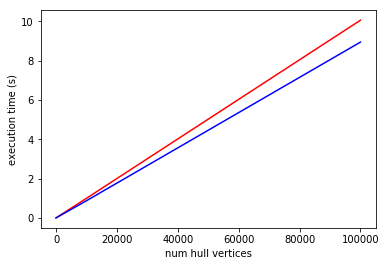

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X_original, Y_original, 'r')
plt.plot(X_indexing, Y_indexing, 'b')
plt.xlabel('num hull vertices')
plt.ylabel('execution time (s)')
plt.show()
